In [1]:
import pandas as pd
import numpy as np
snoqualmie = pd.read_csv('data/set1.txt', skiprows=1, header=None, delim_whitespace=True)
#rows are 36 years between 1948-1983 and columns are 366 days accounting for leap years
print(snoqualmie.shape)
snoqualmie.head(10)

(36, 366)


,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,365
0,136,100,16,80,10,66,88,38,1,87,...,0,0,0,0,0,0,0,49,114,17.0
1,17,14,0,0,1,11,90,6,0,0,...,107,29,97,47,245,121,72,27,41,NaN
2,1,35,13,13,18,122,22,25,8,48,...,85,43,20,4,40,10,5,93,23,NaN
3,34,183,11,20,11,0,9,1,0,3,...,0,0,0,0,4,19,37,19,0,NaN
4,0,0,2,1,2,7,11,2,37,21,...,10,5,0,0,0,0,43,35,15,13.0
5,2,124,51,2,0,41,113,177,143,5,...,15,0,0,19,2,53,3,7,17,NaN
6,59,48,44,121,130,90,42,33,13,0,...,63,51,22,1,0,26,61,109,26,NaN
7,32,36,0,4,16,0,0,0,0,0,...,27,10,12,72,26,0,0,0,0,NaN
8,48,52,141,106,50,74,51,8,10,1,...,12,33,0,0,0,0,0,0,5,14.0
9,43,12,9,1,0,0,68,34,0,8,...,72,46,130,35,65,118,21,5,0,NaN


In [2]:
# preprocess the data...
# columns will be year, day, rainfall today, rainfall tomorrow
from itertools import cycle
rainfall_sequence = snoqualmie.values.flatten()
rainfall_sequence = rainfall_sequence[~np.isnan(rainfall_sequence)]

snoq = pd.DataFrame(columns=['year','day','rainfall today','rainfall tomorrow','rained today?','rained tomorrow?'])
years = range(1948,1984)
days_per_year = cycle((366, 365, 365, 365))
for year_i, num_days in zip(range(len(years)), days_per_year):
    if years[year_i] == years[-1]: #last year in data
        year_vec = [int(years[year_i])]*(num_days-1)
        day_vec = range(1,num_days)
        today_rainfall = np.array(rainfall_sequence[year_i*num_days:(year_i+1)*num_days-1])
        tomorrow_rainfall = np.array(rainfall_sequence[year_i*num_days+1:(year_i+1)*num_days])
    else:
        year_vec = [int(years[year_i])]*num_days
        day_vec = range(1,num_days+1)
        today_rainfall = rainfall_sequence[year_i*num_days:(year_i+1)*num_days]
        tomorrow_rainfall = rainfall_sequence[year_i*num_days+1:(year_i+1)*num_days+1]
    rained_today = today_rainfall > 0
    rained_tomorrow = tomorrow_rainfall > 0
    yf = pd.DataFrame({'year': year_vec, 'day': day_vec, 'rained today?': rained_today, 'rained tomorrow?': rained_tomorrow,
                       'rainfall today': today_rainfall,'rainfall tomorrow':tomorrow_rainfall })
    snoq = pd.concat([snoq, yf], axis=0, ignore_index=True)

snoq.tail(15)

,day,rained today?,rained tomorrow?,rainfall today,rainfall tomorrow,year
13133,350,False,True,0.0,64.0,1983
13134,351,True,True,64.0,38.0,1983
13135,352,True,True,38.0,124.0,1983
13136,353,True,True,124.0,27.0,1983
13137,354,True,False,27.0,0.0,1983
13138,355,False,True,0.0,78.0,1983
13139,356,True,True,78.0,30.0,1983
13140,357,True,True,30.0,15.0,1983
13141,358,True,False,15.0,0.0,1983
13142,359,False,False,0.0,0.0,1983


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

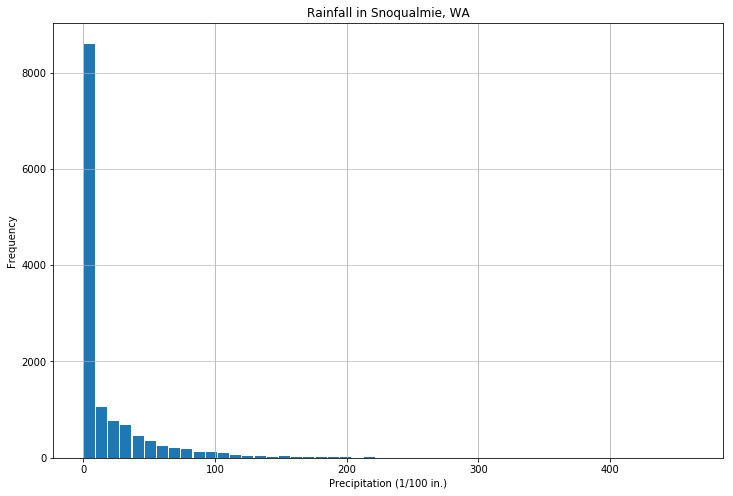

In [4]:
plt.close('all')
snoq['rainfall today'].plot.hist(bins=50, rwidth=0.9, grid=True, figsize=(12,8));
plt.title('Rainfall in Snoqualmie, WA')
plt.xlabel('Precipitation (1/100 in.)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

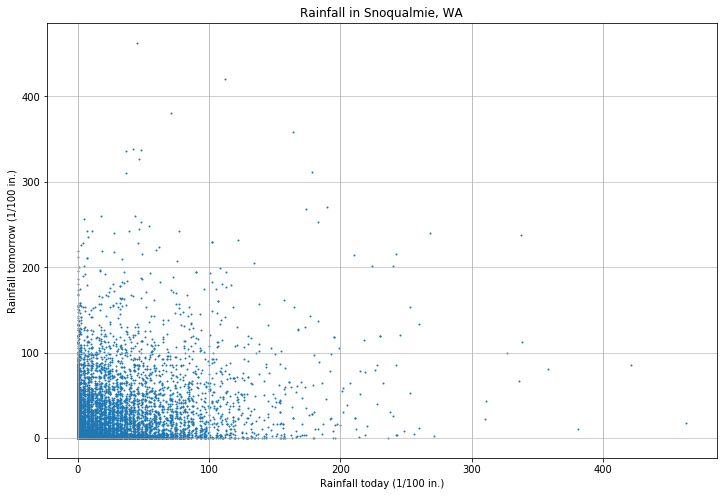

In [5]:
plt.close('all')
snoq.plot.scatter(x='rainfall today', y='rainfall tomorrow', s=1, grid=True, figsize=(12,8));
plt.title('Rainfall in Snoqualmie, WA')
plt.xlabel('Rainfall today (1/100 in.)')
plt.ylabel('Rainfall tomorrow (1/100 in.)')
plt.grid(axis='y', alpha=0.75)

In [6]:
# the data to use in the fit
X1 = snoq['rainfall today'].values.reshape(-1,1)
# add a column of ones at the beginning for the bias term
ones = np.ones(X1.shape[0]).reshape(-1,1)
X = np.concatenate((ones,X1), axis=1) 
print(X[:5])
n_features = X.shape[1]
# The thing we want to predict
Y = snoq['rained tomorrow?'].values.astype(int).reshape(-1,1)

[[  1. 136.]
 [  1. 100.]
 [  1.  16.]
 [  1.  80.]
 [  1.  10.]]


## Description

The $Y$ variable is binary, either zero or one. The $X$ is a range of real numbers. We want to predict $Pr(Y=1|X=x)$. $Pr(Y=0|X=x)$ will just be $1 - Pr(Y=1|X=x)$. The optimal solution at every point x is the expectation value of the variable Y, i.e. $E[Y|X=x]$.

To predict a probability distribution, the likelihood of the probability distribution (which is defined on the sample) should be maximized, or equivalently the minimum of the negative 2 log likelihood. 

$$L = \prod_i P(y_i; x_i, \theta) \qquad -2 \text{log}[L] = -2 \sum_i \text{log}[P(y_i; x_i, \theta)]$$

Since Y is only 1 or 0, we can re-write $P(y_i; x_i, \theta) = P(x_i, \theta)^{y_i}(1 - P(x_i, \theta))^{1-y_i}$

If our model is logistic regression for the binary Y, we want want the fit to be linear with respect to the log odds, i.e. $ \frac{p(x)}{1-p(x)} = \theta \cdot X$, which rewritten to be plugged into the likelihood would be 

$$ P(x_i, \theta) = \frac{1}{1 + e^{-(\theta \cdot X)}}$$ 

Thus making the -2 log likelihood is 

$$ -2 \text{log}[L] = -2 \sum_i -\text{log}(1+e^{\theta \cdot x_i}) + y_i*(\theta \cdot x_i)$$

In [7]:
# define the loss function to minimize. We are using a linear logistic model
def neg2_log_likelihood(X,Y):
    assert(len(X.shape)==2),"must be 2D array with measurements in rows and features in cols"
    assert(X.shape[0] == Y.size),"x size is {}, y size is {}. must be the same".format(X.shape[0],y.size)
    def f(theta):
        logl = 0
        linear = np.dot(X,theta.reshape(-1,1))
        logl = sum(-1.0*np.log(1+np.exp(linear)) + Y*(linear))
        return -2.0*logl
    return f

#the long way, not using matrix multiplication
#for (xi,yi) in zip(X,Y):
#    logl += -1.0*np.log(1+np.exp(np.dot(np.transpose(theta),xi))) + yi*(np.dot(np.transpose(theta),xi))

In [8]:
# Given a list of linear parameters (intercept and slopes), gives the regression curve
# Also can gives the confidence interval functions by providing the covariance matrix of the predictions
# Assumes a gaussian when creating the confidence interval
def logit_regression(theta,X,cov_mat=None):
    n_features = len(theta)
    cov_mat = np.eye(n_features) if cov_mat is None else cov_mat
    def f(x, cl):
        center = np.dot(x,theta.reshape(-1,1))
        #error propagation
        variances = np.sum(np.dot(x,np.dot(cov_mat,np.transpose(x)))*np.eye(x.shape[0]), axis=1)
        std_err = (cl*np.sqrt(variances)).reshape(-1,1)
        #result
        y = 1./(1.+np.exp(-(center+std_err)))
        return y
    return f

def line_regression(theta,X,cov_mat=None):
    n_features = len(theta)
    cov_mat = np.eye(n_features) if cov_mat is None else cov_mat
    def f(x, cl):
        center = np.dot(x,theta.reshape(-1,1))
        #error propagation
        variances = np.sum(np.dot(x,np.dot(cov_mat,np.transpose(x)))*np.eye(x.shape[0]), axis=1)
        std_err = (cl*np.sqrt(variances)).reshape(-1,1)
        #result
        y = center+std_err
        return y
    return f

In [9]:
from iminuit import Minuit
# MINUIT is a suite for numerical minimization and error estimation, originally written in FORTRAN
# minimize your loss function of choice with the migrad method (gradient descent)
# This is a numerical way of estimating the minimum, 
# rather than an analytical solution like the normal equation
para_names = ['beta'+str(i) for i in range(n_features)]
snoq_likelihood = neg2_log_likelihood(X,Y)
nuit = Minuit.from_array_func(snoq_likelihood, (0.5,0.5), error=(0.1,0.1), name = tuple(para_names), errordef = 0.5)
nuit.migrad();
best_theta = np.array(nuit.values.values())
print('minimum for the sample: {}'.format(snoq_likelihood(best_theta)))
#print('likelihood: {}'.format(snoq_likelihood(np.array((best_theta[0]+.1,best_theta[1]-.1)))))

FCN = 15889.30547192165 
 TOTAL NCALL = 83 
 NCALLS = 83 
 
 
 EDM = 3.351064068066203e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 beta0 
 -0.436358 
 0.0152939 
 
 
 
 
 No 
 
 
 1 
 beta1 
 0.0453883 
 0.000926627 
 
 
 
 
 No

minimum for the sample: [15889.30547192]


In [10]:
#get the regression functions using the best fit estimators
sample_best_fit_curve = logit_regression(best_theta,X)
# get the xaxis and the prediction for x
xaxis = np.linspace(0,500,500).reshape(-1,1)
x_values = np.concatenate((np.ones(xaxis.size).reshape(-1,1), xaxis),axis=1)
# draw the y axis
yaxis = sample_best_fit_curve(x_values, 0)

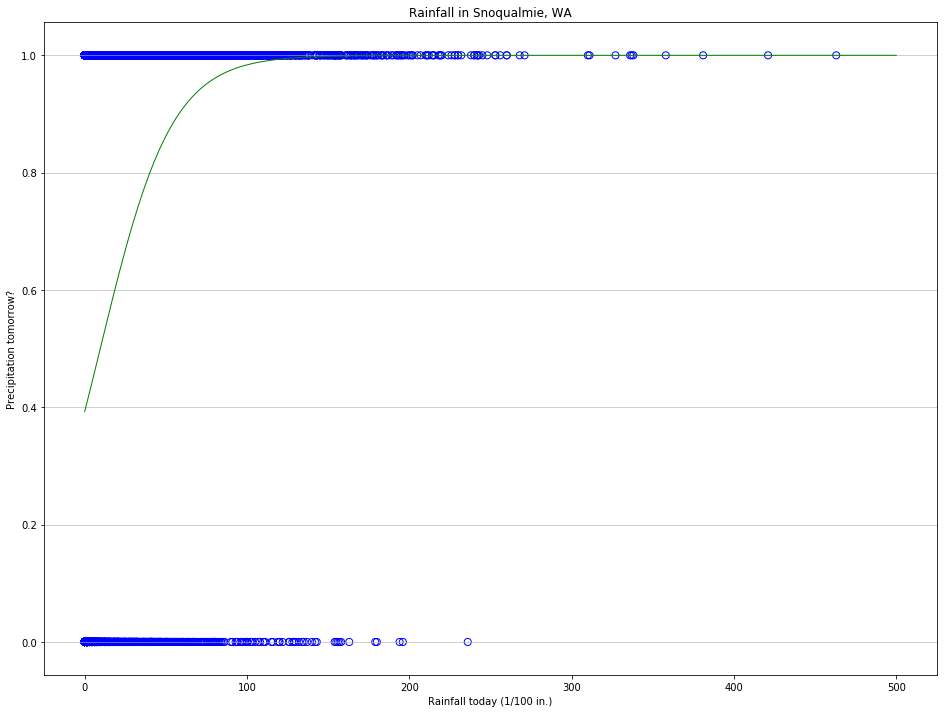

In [11]:
plt.close('all')
plt.figure(figsize=(16,12))
plt.scatter(x=snoq['rainfall today'].values, y=snoq['rained tomorrow?'].values, s=50, color='blue',marker='o',facecolors='none');
plt.plot(xaxis,yaxis, linewidth=1,color='green') #regression line
plt.title('Rainfall in Snoqualmie, WA')
plt.xlabel('Rainfall today (1/100 in.)')
plt.ylabel('Precipitation tomorrow?')
plt.grid(axis='y', alpha=0.75)

# Propagating errors

To draw the confidence interval around our regression, we will use the Hessian errors, since they include the covariances of the estimators. We will get the confidence band around $E[Y|X=x]$ by using the sum of correlated random variables..

We define Z as the population parameter of the log-odds of it raining, given X=x. $B$ are the optimal parameters that maximize the likelihood when we are forced to use a logistic model.  

$$ Z(X=x) = \text{log}\frac{E[Y|X=x]}{1-E[Y|X=x]} = B_0 + x \cdot B $$

We do not have access to the whole population, but just the sample that was provided above. In that case we have estimated Z using the best-fit parameters $\theta_0$ and $\theta$, calculated from the maximum likelihood of our sample. We call this estimate $\hat{Z}$ and try to find the confidence band around it with the following equation:

$$ V[\hat{Z}(X=x)] = V[\sum_i x_i \theta_i] = \sum_{i=1}^n x_i^2 V[\theta_i] + \sum_{1 \leq i \lt j}^n 2 x_i x_j Cov[\theta_i, \theta_j] $$

The $x_i$ here are the features associated with each $\theta_i$, and not the individual $x$ measurements in the sample.

These confidence intervals only account for variance in the estimated parameters, and they do not account for the possible bias of the fit. i.e. the logistic regression may not be the most optimal model to maximize the likelihood. These confidence intervals will not capture the uncertainty due to using a suboptimal model.

In [12]:
# Numerically calculate the hessian (for getting the correlation matrix of the errors). 
# Inverse of Hessian gives symmetric errors and assumes a multivariate gaussian distribution for the estimators
from pprint import pprint
nuit.hesse()
cov_matrix = nuit.np_matrix()
pprint(cov_matrix) 
print('std_dev b: {} \n std_dev m: {}'.format(np.sqrt(cov_matrix[0][0]),np.sqrt(cov_matrix[1][1])))

Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 beta0 
 -0.436358 
 0.0152933 
 
 
 
 
 No 
 
 
 1 
 beta1 
 0.0453883 
 0.000926587 
 
 
 
 
 No

beta0 beta1 
 
 
 beta0 1.00 -0.48 
 
 
 beta1 -0.48 1.00

array([[ 2.33883814e-04, -6.84005393e-06],
       [-6.84005393e-06,  8.58564025e-07]])
std_dev b: 0.015293260399048316 
 std_dev m: 0.00092658730043826


In [13]:
# Can check the Hessian errors with MINOS, which utilizes profile likelihood to get the variances
# Since it uses profile likelihood, it does not give covariances.
# If the errors are comparable, then the asymptotic assumptions of the Hessian are all right
nuit.minos()
pprint(nuit.merrors)

Error,-0.015297673224241089,0.015299467236875646
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0009231702692846029,0.0009305996512600799
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


{('beta0', -1.0): -0.015297673224241089,
 ('beta0', 1.0): 0.015299467236875646,
 ('beta1', -1.0): -0.0009231702692846029,
 ('beta1', 1.0): 0.0009305996512600799}


In [14]:
sample_best_fit_curve = logit_regression(best_theta,X,cov_matrix)
# get the confidence intervals for the regression curve
xaxis = np.linspace(0,500,500).reshape(-1,1)
x_values = np.concatenate((np.ones(xaxis.size).reshape(-1,1), xaxis),axis=1)
yaxis_1err = sample_best_fit_curve(x_values, 1.96)
yaxis_neg1err = sample_best_fit_curve(x_values, -1.96)

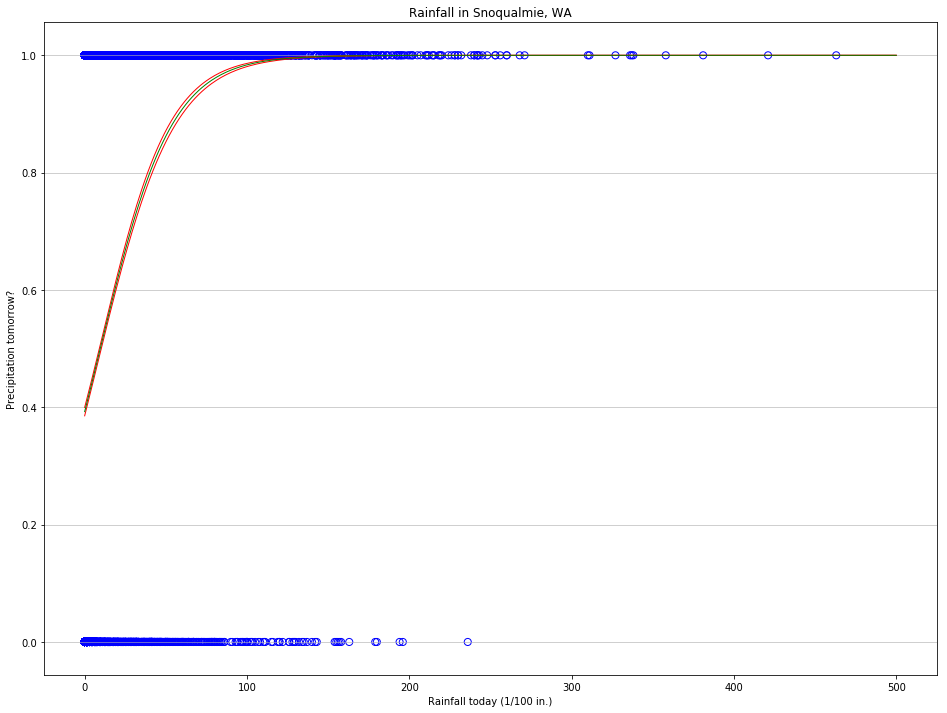

In [15]:
plt.close('all')
plt.figure(figsize=(16,12))
plt.scatter(x=snoq['rainfall today'].values, y=snoq['rained tomorrow?'].values, s=50, color='blue',marker='o',facecolors='none');
plt.plot(xaxis,yaxis_1err, linewidth=1,color='red') # 95% confidence up assuming Gaussian errors on estimators
plt.plot(xaxis,yaxis_neg1err, linewidth=1,color='red') # 95% confidence down assuming Gaussian errors on estimators
plt.plot(xaxis,yaxis, linewidth=1,color='green') #regression line
plt.title('Rainfall in Snoqualmie, WA')
plt.xlabel('Rainfall today (1/100 in.)')
plt.ylabel('Precipitation tomorrow?')
plt.grid(axis='y', alpha=0.75)
# These confidence intervals only account for variance, they do not account for the possible bias of the fit. 
# I.e. logistic regression may not be the most optimal model to maximizes the likelihood.

# Checking for bias

We can check for bias in the parametric logistic fit by doing a fit to a non-parametric model and comparing their maximum likelihoods. 

# Add another feature to the logistic fit

Now we are going to add a simple binary feature to the regression about whether it rained today or not. The information is implicitly already in `rainfall_today`, but making the fact that it rained today (even if it was just a little) an explicit True/False feature may improve the logistic model and get a more optimal sample minimum likelihood value. 

In [30]:
# add another columns of data to use in the fit
X2 = snoq['rained today?'].values.astype(int).reshape(-1,1)
Xextend = np.concatenate((X,X2), axis=1)
print(Xextend[9:15])
n_features_extend = Xextend.shape[1]

[[ 1. 87.  1.]
 [ 1.  8.  1.]
 [ 1.  4.  1.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]]


In [25]:
para_names_extend = ['beta'+str(i) for i in range(n_features_extend)]
snoq_likelihood_extended = neg2_log_likelihood(Xextend,Y)
nuit_extended = Minuit.from_array_func(snoq_likelihood_extended, (0.5,0.5,0.5), error=(0.1,0.1,0.1), name = tuple(para_names_extend), errordef = 0.5)
nuit_extended.migrad();
better_theta = np.array(nuit_extended.values.values())
print('minimum likelihood for the sample with two features: {}'.format(snoq_likelihood_extended(better_theta)))
print('minimum likelihood for the sample with one feature: {}'.format(snoq_likelihood(best_theta)))
nuit_extended.hesse()
cov_matrix_extended = nuit_extended.np_matrix()

FCN = 14937.495756275111 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = 1.9263761589108245e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 beta0 
 -0.914042 
 0.0197678 
 
 
 
 
 No 
 
 
 1 
 beta1 
 0.0208574 
 0.000869501 
 
 
 
 
 No 
 
 
 2 
 beta2 
 1.43782 
 0.0330424 
 
 
 
 
 No

minimum likelihood for the sample with two features: [14937.49575628]
minimum likelihood for the sample with one feature: [15889.30547192]


Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 beta0 
 -0.914042 
 0.0198141 
 
 
 
 
 No 
 
 
 1 
 beta1 
 0.0208574 
 0.000869793 
 
 
 
 
 No 
 
 
 2 
 beta2 
 1.43782 
 0.0332898 
 
 
 
 
 No

beta0 beta1 beta2 
 
 
 beta0 1.00 -0.00 -0.59 
 
 
 beta1 -0.00 1.00 -0.54 
 
 
 beta2 -0.59 -0.54 1.00

In [26]:
#get the regression function using the best fit estimators
sample_better_fit_curve = logit_regression(better_theta,Xextend,cov_matrix_extended)
# get the xaxis and the prediction for x and that it will rain (X2=1 everywhere)
x2_values = np.concatenate((x_values, np.ones(xaxis.size).reshape(-1,1)),axis=1)
# draw the y axis
y2_axis = sample_better_fit_curve(x2_values, 0)
y2_axis_1err = sample_better_fit_curve(x2_values, 1.96)
y2_axis_neg1err = sample_better_fit_curve(x2_values, -1.96)

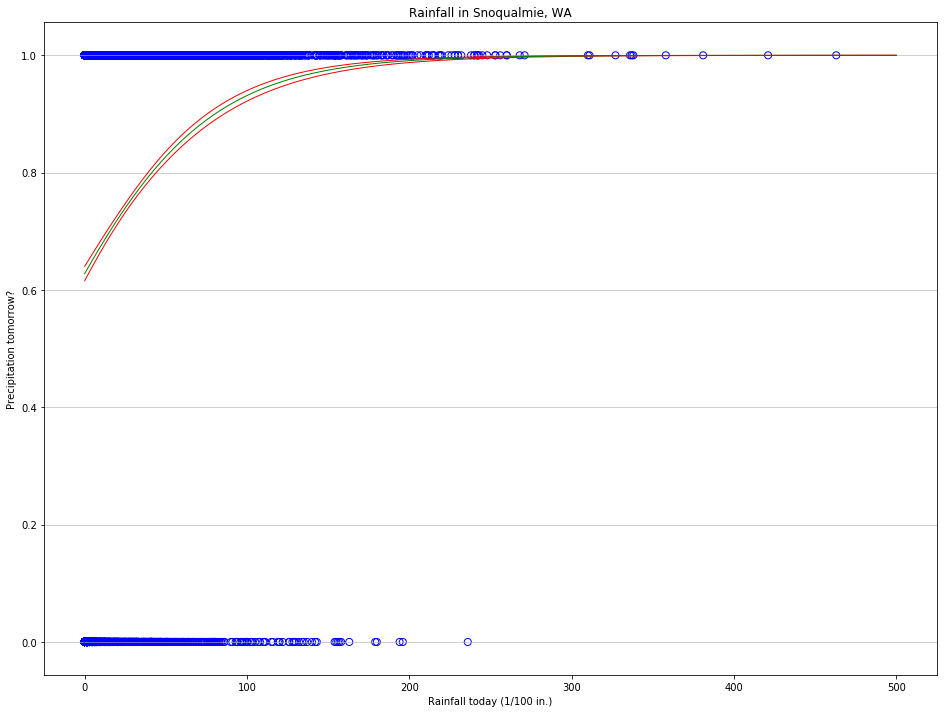

In [27]:
plt.close('all')
plt.figure(figsize=(16,12))
plt.scatter(x=snoq['rainfall today'].values, y=snoq['rained tomorrow?'].values, s=50, color='blue',marker='o',facecolors='none');
plt.plot(xaxis,y2_axis_1err, linewidth=1,color='red') # 95% confidence up assuming Gaussian errors on estimators
plt.plot(xaxis,y2_axis_neg1err, linewidth=1,color='red') # 95% confidence down assuming Gaussian errors on estimators
plt.plot(xaxis,y2_axis, linewidth=1,color='green') #regression line
plt.title('Rainfall in Snoqualmie, WA')
plt.xlabel('Rainfall today (1/100 in.)')
plt.ylabel('Precipitation tomorrow?')
plt.grid(axis='y', alpha=0.75)